# Loading and correcting data for RhFe 
# P22 beamtime  in November 2018

In [1]:
%load_ext autoreload
%autoreload 2
%gui tk

In [2]:
#Imports
# Embedded imports
import os, sys
import copy
import math
import matplotlib.pyplot as plt
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp
# Temporary solution for local imports
sys.path.append('..')
from xpstool import helpers 
from xpstool import Experiment, Spectrum, Region
from xpstool import Fitter

In [3]:
# Constants
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline
# All fields below are taken from Scienta.txt file except "Conditions",
# which is added manually upon data processing
min_info = [
    "Region Name",
    "Pass Energy",
    "Number of Sweeps",
    "Energy Step",
    "Date",
    "Time",
    "File",
    "Conditions"
]

In [4]:
# ---SCIENTA DATA FOLDERS---
# Full path to data files
data_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data"
# Full path to output files
output_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/ProcessedData"

file_names = []
file_idx = 0
for file in sorted(os.listdir(data_folder)):
    if file.endswith(".txt"):                         
        file_names.append(file)
        #print(f"---> file[{file_idx}]: {file}")
        file_idx += 1

**Files from 0000 to 0157 were measured at 4600 eV photon energy**

**File 0158 was measured at 3700 eV photon energy (IGNORE)**

**Files from 0159 to 0347 were measured at 3800 eV photon energy**

## <font color ='blue'>First experiment H2 : CO2 = 1 : 1 at ~50 mbar</font>

### Overview
Analyser properties: <br>
>    Slit = 0.8 (?) <br>
    Pass energy: 100 <br>
    <br>
    Experimental broadening (Gaussian + Lorenzian): <br>
    ~0.54 eV -- ~0.59 eV (depending on temperature)  <br>

In [5]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0002",
    "0014",
    "0019",
    "0024",
    "0029",
    "0034",
    "0039",
    "0044",
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0004", "0003", "0005", "0007"],
    ["0011", "0008", "0013", "0012"],
    ["0016", "0015", "0018", "0017"],
    ["0021", "0020", "0023", "0022"],
    ["0025", "0026", "0028", "0027"],
    ["0031", "0030", "0033", "0032"],
    ["0036", "0035", "0038", "0037"],
    ["0041", "0040", "0043", "0042"]
]
conditions = [
    {"Temperature": "25 C"},
    {"Temperature": "150 C"},
    {"Temperature": "200 C"},
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"}
]

# Create an Experiment object to store spectra specified above
exp = Experiment()
exp.setExcitationEnergy(p22_energy_4600)

# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]))
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        spectrum._setConditions(conditions[i])
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
             print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp.addSpectrum(num, spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]))
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            spectrum._setConditions(conditions[i])
            exp.addSpectrum(numstr, spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

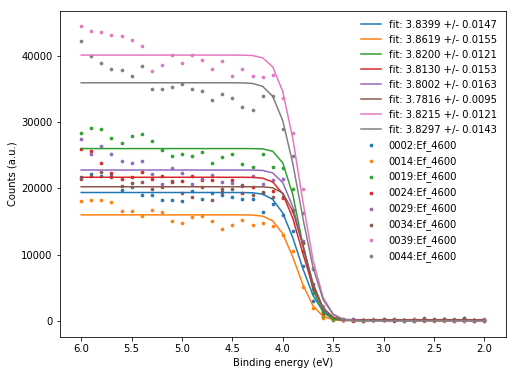

In [6]:
# Adjusting and plotting Fermi regions
shifts = []
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding(p22_energy_4600)
    helpers.plotRegion(fermi_region, figure=fig.number, scatter=True, title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, fit_parameters, add_column=True)
    shifts.append(fit_res)
    helpers.plotRegion(fermi_region, figure=fig.number, y_data="fitFermi", label=f"fit: {fit_res[0]:.4f} +/- {fit_res[1]:.4f}", title=False)

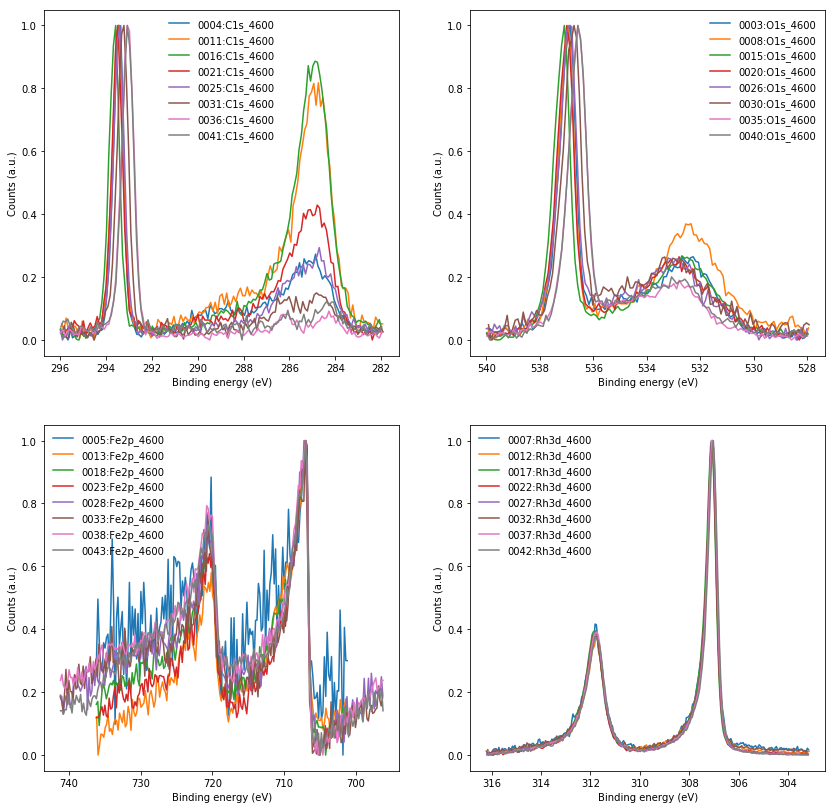

In [7]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        scan.invertToBinding(exp.getExcitationEnergy())
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540, stop=528, changesource=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
        # Subtract Shirley or linear background
        #l_background = helpers.calculateLinearBackground(scan, add_column=True)
        helpers.calculateShirley(scan, add_column=True)
        helpers.normalize(scan, y_data="shirleyBG", add_column=True)
        # Plotting spectra with Shirley background subtracted
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="normalized", title=False)

In [8]:
# # Finalized cropping of specified regions (not copies as above)
# for i, single_set in enumerate(scan_sets): 
#     for j, scan_num in enumerate(single_set):
#         scan = exp.getSpectrum(scan_num).getRegion()
#         # Crop O1s regions
#         if j == 1:
#             scan.cropRegion(start=540, stop=528, changesource=True)
#         # Crop C1s regions
#         if j == 0:
#             scan.cropRegion(start=296, stop=282, changesource=True)

### Experiment step by step

Start with the following flows <br>
<font color ='red'>CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br></font>

#### 1. Room temperature <br>
First diff pumping stage pressure 5.6e-4 <br>
Files: <br>
>    Ef_4600 - 0002.txt <br>
    O1s_4600 - 0003.txt <br>
    C1s_4600 - 0004.txt <br>
    Fe2p_4600 - 0005.txt <br>
    Rh3d_4600 - 0007.txt <br>

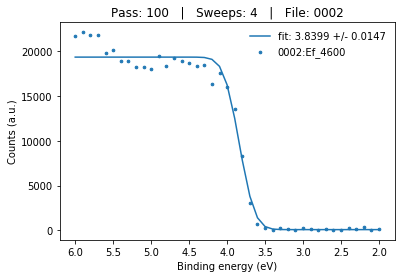

In [9]:
# Set #1
set_num = 0 
helpers.plotRegion(exp.getSpectrum(fermi_nums[set_num]).getRegion(), 
                                   figure=1, scatter=True)
helpers.plotRegion(exp.getSpectrum(fermi_nums[set_num]).getRegion(),
                                   figure=1, y_data="fitFermi", 
                                   label=f"fit: {shifts[set_num][0]:.4f} +/- {shifts[set_num][1]:.4f}")

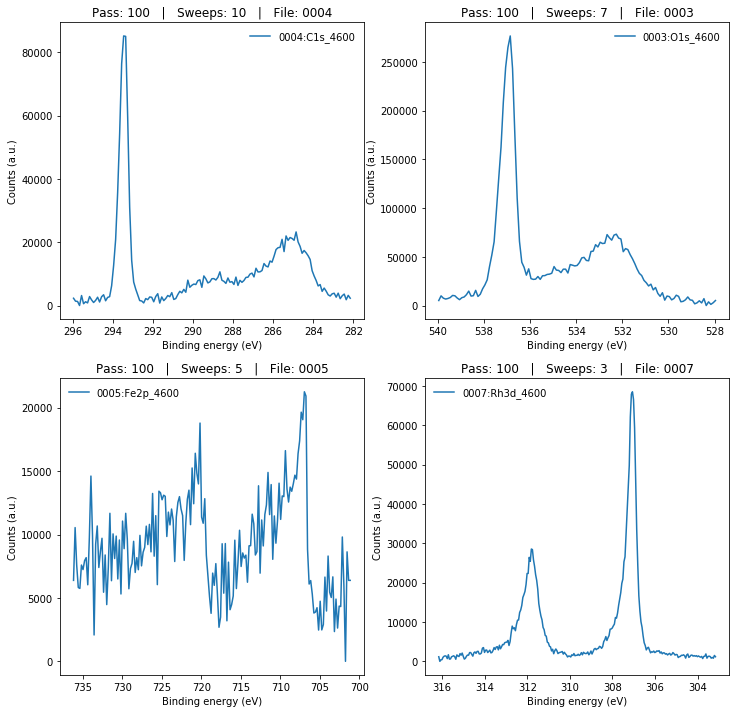

In [10]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax = [ax1, ax2, ax3, ax4]
for i, scan_num in enumerate(scan_sets[set_num]):
    # Plotting corrected spectra
    helpers.plotRegion(exp.getSpectrum(scan_num).getRegion(),
                       figure=fig.number, 
                       ax=ax[i], y_data="shirleyBG")

--- Peak #1 ---
Type: voigt
wg: 0.5001 (+/- 0.0806)
amplitude: 52188.5866 (+/- 4811.6216)
center: 293.4576 (+/- 0.0030)
width: 0.1638 (+/- 0.0040)
Area: 499936.7185
--- Peak #2 ---
Type: voigt
wg: 0.4999 (+/- 0.1526)
amplitude: 12300.4186 (+/- 4586.1313)
center: 288.8387 (+/- 0.0018)
width: 1.6077 (+/- 0.0341)
Area: 352116.9709
--- Peak #3 ---
Type: voigt
wg: 0.5001 (+/- 0.0556)
amplitude: 29053.4303 (+/- 1176.0272)
center: 285.1549 (+/- 0.0016)
width: 0.9067 (+/- 0.0121)
Area: 567435.7644


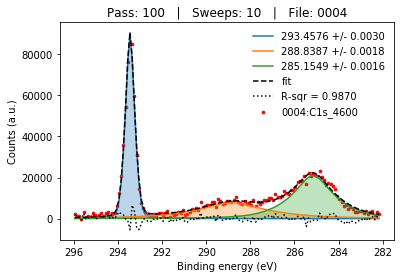

In [21]:
scan = exp.getSpectrum(scan_sets[0][0]).getRegion()
#scan = scan.cropRegion(start=293)
fitter = Fitter(scan, y_data="shirleyBG")
initial_guess = [ # wg, amp, cen, width
    0.5, 70000, 294, 0.54,
    0.5, 10000, 289, 0.54,
    0.5, 30000, 285, 0.54
#     10000, 308.5, 0.3
]
fitter.fitVoigt(initial_guess, fix_ratio=True, fix_width=False)
print(fitter)
helpers.plotRegion(scan, y_data="shirleyBG", color='red', scatter=True)
for peak in fitter.getPeaks():
    helpers.plotPeak(peak)
helpers.plotFit(fitter, addresiduals=True)

--- Peak #1 ---
Type: voigt
wg: 0.5001 (+/- 0.1184)
amplitude: 27229.4744 (+/- 5090.7487)
center: 307.0656 (+/- 0.0031)
width: 0.1232 (+/- 0.0059)
Area: 486222.8770
--- Peak #2 ---
Type: voigt
wg: 0.4999 (+/- 0.0215)
amplitude: 19106.4644 (+/- 2391.6039)
center: 307.4256 (+/- 0.0059)
width: 0.4486 (+/- 0.0053)
Area: 501178.0095


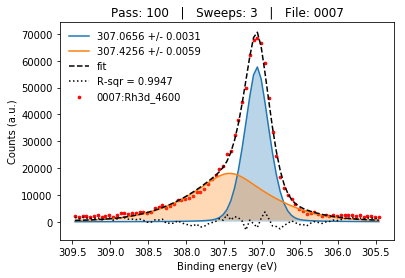

In [13]:
scan = exp.getSpectrum(scan_sets[0][3]).getRegion()
scan = scan.cropRegion(start=309.5, stop=305.5)
fitter = Fitter(scan, y_data="shirleyBG")
initial_guess = [ # wg, amp, cen, width
    0.5, 70000, 307, 0.2,
    0.5, 10000, 308, 1
    #0.5, 30000, 312, 0.35
]
fitter.fitVoigt(initial_guess, fix_ratio=True)
print(fitter)
helpers.plotRegion(scan, y_data="shirleyBG", color='red', scatter=True)
for peak in fitter.getPeaks():
    helpers.plotPeak(peak)
helpers.plotFit(fitter, addresiduals=True)

#### 2. 150 C <br>
CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br>
First diff pumping stage pressure 3.3e-4 <br>
Files: <br>
>    Ef_4600 - 0014.txt <br>
    O1s_4600 - 0008.txt <br>
    C1s_4600 - 0011.txt <br>
    Fe2p_4600 - 0013.txt <br>
    Rh3d_4600 - 0012.txt <br>

In [14]:
help(sp.optimize.curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the function
        can be det

In [15]:
bounds = (-inf, inf)

NameError: name 'inf' is not defined

In [ ]:
10%5